In [117]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_auc_score

import os
from functools import reduce

from scipy.stats import ks_2samp
from scikitplot.metrics import plot_ks_statistic,plot_roc_curve

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',500)
pd.set_option('display.float_format',lambda x:'%.8f'%x)

## Cargar datos y categorizar variables

In [2]:
ruta='/home/oszwaldo/Documentos/Projects/Selectos/Unidad 2/Hojas de c√°lculo'
r=os.listdir('/home/oszwaldo/Documentos/Projects/Selectos/Unidad 2/Hojas de c√°lculo')[1]
arch= os.path.join(ruta,r)
arch

'/home/oszwaldo/Documentos/Projects/Selectos/Unidad 2/Hojas de c√°lculo/Cuestionario Diagn√≥stico 2019 - 1 (Respuestas).xlsx'

In [3]:
df = pd.read_excel(arch)
print(df.shape)
df = df.loc[df['Edad üéÇ']<=40].reset_index(drop=True)
df = df.loc[df['¬øCu√°ntos cuartos para dormir tiene tu vivienda?']>0].reset_index(drop=True)
df = df.loc[df['¬øA cu√°nto aproximadamente ascienden los ingresos de tu hogar(considerando a todos los que aportan)?']<=100000].reset_index(drop=True)
df = df.loc[df['¬øEn cu√°ntos a√±os lo terminaste?']<=5].reset_index(drop=True)
print(df.shape)

(228, 81)
(222, 81)


In [4]:
varc = ['Edad üéÇ',
        '¬øCu√°nto tiempo dura (en minutos) el trayecto de tu casa a la facultad? ‚è±',
        '¬øCu√°ntas personas en total viven en tu hogar? Incluy√©ndote a ti',
        '¬øCu√°ntos son hombres?',
        '¬øCu√°ntas son mujeres?',
        '¬øCu√°nto tiempo llevas viviendo ah√≠? (a√±os)',
        '¬øCu√°ntos cuartos para dormir tiene tu vivienda?',
        '¬øCu√°ntos autom√≥viles en total tienen las personas que conforman tu hogar?',
        '¬øCu√°ntas horas trabajas a la semana?',
        '¬øQu√© promedio obtuviste en el bachillerato?',
        '¬øEn cu√°ntos a√±os lo terminaste?',
        '¬øA cu√°nto aproximadamente ascienden los ingresos de tu hogar(considerando a todos los que aportan)?',
        '¬øCu√°ntos d√≠as a la semana dedicas tiempo para realizar las siguientes actividades? [Deportes ‚öΩÔ∏èüèÄüèà]',
        '¬øCu√°ntos d√≠as a la semana dedicas tiempo para realizar las siguientes actividades? [Actividades culturales üé≠üé¨üéª]',
        '¬øCu√°ntos d√≠as a la semana dedicas tiempo para realizar las siguientes actividades? [Actividades sociales (fiestas, reuniones con amigos, familia, etc.)]',
        '¬øCu√°ntos d√≠as a la semana dedicas tiempo para realizar las siguientes actividades? [Entretenimiento personal (videojuegos, redes sociales, netflix, youtube, etc)]'
       ]

vard = ['Estado civil','¬øTienes hijos?',
        '¬øTienes alguna dificultad para? [üëì Ver]',
        '¬øTienes alguna dificultad para? [üëÇ Escuchar]',
        '¬øTienes alguna dificultad para? [üí™ Realizar alguna actividad f√≠sica]',
        '¬øD√≥nde vives actualmente?',
        '¬øEn qu√© delegaci√≥n o municipio?',
        '¬øQu√© medio de transporte utilizas para llegar a la facultad?',
        '¬øCu√°l de las siguientes opciones describe tu tipo de vivienda?',
        '¬øCon qui√©n vives? (Puedes seleccionar m√°s de una)',
        '¬øCu√°l es el m√°ximo nivel de estudios de tu pap√°?',
        '¬øCu√°l es el m√°ximo nivel de estudios de tu mam√°?',
        'En caso de que tengas smartphone ¬øQu√© sistema operativo tiene?',
        '¬øD√≥nde vivir√°s mientras cursas tus estudios universitarios?',
        '¬øDe qu√© forma financiar√°s tus estudios universitarios?',
        '¬øEn d√≥nde cursaste el bachillerato?','¬øC√≥mo se llama la instituci√≥n donde cursaste el bachillerato?',
        '¬øRecibiste alguna beca?','¬øCu√°l fue el proceso de admisi√≥n por el que entraste a esta carrera?',
        'Escoger √©sta carrera fue...','Al escoger la FES Acatl√°n √©sta fue:',
        '¬øCu√°ndo tomaste la decisi√≥n de lo que quer√≠as estudiar?'   
       ]
tgt = 'Carrera'

## Normalizar variables discretas

In [5]:
for v in vard:
    df[v].fillna('MISSING',inplace=True)

In [6]:
def normalizar(df,v,umbral=0.05):
    aux = df[v].value_counts(True).to_frame()
    aux['norm'] = np.where(aux[v]<umbral,'Otros',aux.index)
    grupo = aux.loc[aux['norm']=='Otros'][v].sum()
    if grupo<umbral:
        aux['norm'].replace({'Otros':aux.index[0]},inplace=True)
    aux.drop(v,axis=1,inplace=True)
    return v,aux.to_dict()['norm']

In [7]:
l_norm = list(map(lambda v:normalizar(df,v),vard)    )

In [8]:
normalizar(df,'Estado civil')

('Estado civil',
 {'üë§ Soltero': 'üë§ Soltero',
  'üë• En una relaci√≥n': 'üë• En una relaci√≥n',
  'üíç Casado': 'üë§ Soltero'})

In [9]:
f'n_{vard[0]}'

'n_Estado civil'

In [10]:
for v,d in l_norm:
    df[f'n_{v}'] = df[v].replace(d)

In [11]:
varn = df.filter(like='n_').columns.tolist()

In [12]:
for v in varn:
    print(v,'\n')
    print(df[v].value_counts(True).sort_index())
    print('\n'*2)

n_Estado civil 

üë§ Soltero           0.7793
üë• En una relaci√≥n   0.2207
Name: n_Estado civil, dtype: float64



n_¬øTienes hijos? 

No   1.0000
Name: n_¬øTienes hijos?, dtype: float64



n_¬øTienes alguna dificultad para? [üëì Ver] 

No   0.5135
Si   0.4865
Name: n_¬øTienes alguna dificultad para? [üëì Ver], dtype: float64



n_¬øTienes alguna dificultad para? [üëÇ Escuchar] 

No   1.0000
Name: n_¬øTienes alguna dificultad para? [üëÇ Escuchar], dtype: float64



n_¬øTienes alguna dificultad para? [üí™ Realizar alguna actividad f√≠sica] 

No   1.0000
Name: n_¬øTienes alguna dificultad para? [üí™ Realizar alguna actividad f√≠sica], dtype: float64



n_¬øD√≥nde vives actualmente? 

CDMX               0.3829
Estado de M√©xico   0.6171
Name: n_¬øD√≥nde vives actualmente?, dtype: float64



n_¬øEn qu√© delegaci√≥n o municipio? 

Naucalpan   0.0856
Otros       0.9144
Name: n_¬øEn qu√© delegaci√≥n o municipio?, dtype: float64



n_¬øQu√© medio de transporte utilizas para llegar a l

In [13]:
unarias = [v for v in varn if df[v].value_counts().shape[0]==1]

In [14]:
varn = [v for v in varn if v not in unarias]

In [15]:
df[['¬øCu√°ntas horas trabajas a la semana?']]

¬øCu√°ntas horas trabajas a la semana?
0                                  0.0000
1                                     nan
2                                     nan
3                                  0.0000
4                                  0.0000
..                                    ...
217                                0.0000
218                                0.0000
219                                0.0000
220                                   nan
221                                5.0000

[222 rows x 1 columns]

## Discretizaci√≥n de variables continuas

In [16]:
miss, nomiss = df.loc[df[v].isnull()][[v]],df.loc[~df[v].isnull()][[v]]

In [17]:
miss[[v]].head()

Empty DataFrame
Columns: [n_¬øCu√°ndo tomaste la decisi√≥n de lo que quer√≠as estudiar?]
Index: []

In [18]:
l = []
for v in varc:
    for st in ['uniform','quantile']:
        for k in range(2,6):
            kb = KBinsDiscretizer(n_bins=k,
                                  strategy=st,
                                  encode='ordinal')
            
            miss, nomiss = df.loc[df[v].isnull()][[v]],df.loc[~df[v].isnull()][[v]]    
            kb.fit(nomiss[[v]])
            nombre = f'd_{v}_{k}_{st[:3]}' 
            miss[nombre] = miss[v].fillna('MISSING')
            nomiss[nombre] = pd.cut(nomiss[v],bins=kb.bin_edges_[0],include_lowest=True).astype(str)
            l.append(pd.concat([nomiss[[nombre]],miss[[nombre]]]))
            if df[v].isnull().astype(int).cumsum()[221]>0:
                print(v)
                print(miss[nombre])
                print(nomiss[nombre])

¬øCu√°ntas horas trabajas a la semana?
1      MISSING
2      MISSING
6      MISSING
7      MISSING
9      MISSING
        ...   
208    MISSING
209    MISSING
210    MISSING
216    MISSING
220    MISSING
Name: d_¬øCu√°ntas horas trabajas a la semana?_2_uni, Length: 103, dtype: object
0      (-0.001, 18.5]
3      (-0.001, 18.5]
4      (-0.001, 18.5]
5        (18.5, 37.0]
8      (-0.001, 18.5]
            ...      
215    (-0.001, 18.5]
217    (-0.001, 18.5]
218    (-0.001, 18.5]
219    (-0.001, 18.5]
221    (-0.001, 18.5]
Name: d_¬øCu√°ntas horas trabajas a la semana?_2_uni, Length: 119, dtype: object
¬øCu√°ntas horas trabajas a la semana?
1      MISSING
2      MISSING
6      MISSING
7      MISSING
9      MISSING
        ...   
208    MISSING
209    MISSING
210    MISSING
216    MISSING
220    MISSING
Name: d_¬øCu√°ntas horas trabajas a la semana?_3_uni, Length: 103, dtype: object
0      (-0.001, 12.333]
3      (-0.001, 12.333]
4      (-0.001, 12.333]
5      (12.333, 24.667]
8      (-0.

In [19]:
dfd = reduce(lambda x,y:pd.merge(x,y,left_index=True,right_index=True,how='outer'),l)

In [20]:
dfd.shape,df.shape

((222, 128), (222, 103))

In [21]:
dfd[['d_¬øCu√°ntas horas trabajas a la semana?_2_uni']].head()

d_¬øCu√°ntas horas trabajas a la semana?_2_uni
0                               (-0.001, 18.5]
1                                      MISSING
2                                      MISSING
3                               (-0.001, 18.5]
4                               (-0.001, 18.5]

## Juntar discretas, continuas y target

In [22]:
df[[tgt]+varn]

Carrera     n_Estado civil  \
0    Matem√°ticas Aplicadas y Computaci√≥n          üë§ Soltero   
1    Matem√°ticas Aplicadas y Computaci√≥n          üë§ Soltero   
2    Matem√°ticas Aplicadas y Computaci√≥n          üë§ Soltero   
3    Matem√°ticas Aplicadas y Computaci√≥n  üë• En una relaci√≥n   
4    Matem√°ticas Aplicadas y Computaci√≥n          üë§ Soltero   
..                                   ...                ...   
217                             Actuaria          üë§ Soltero   
218                             Actuaria          üë§ Soltero   
219                             Actuaria  üë• En una relaci√≥n   
220                             Actuaria          üë§ Soltero   
221                             Actuaria          üë§ Soltero   

    n_¬øTienes alguna dificultad para? [üëì Ver] n_¬øD√≥nde vives actualmente?  \
0                                          Si                        CDMX   
1                                          Si            Estado de M√©xico   
2                                          No            Estado de M√©xico   
3                                          Si                        CDMX   
4                                          Si                        CDMX   
..                                        ...                         ...   
217                                        No            Estado de M√©xico   
218                                        Si            Estado de M√©xico   
219                                        Si                        CDMX   
220                                        No                        CDMX   
221                                        Si                        CDMX   

    n_¬øEn qu√© delegaci√≥n o municipio?  \
0                               Otros   
1                           Naucalpan   
2                               Otros   
3                               Otros   
4                               Otros   
..                                ...   
217                             Otros   
218                             Otros   
219                             Otros   
220                             Otros   
221                             Otros   

    n_¬øQu√© medio de transporte utilizas para llegar a la facultad?  \
0    Transporte p√∫blico (metro, metrobus, micro, co...               
1    Transporte p√∫blico (metro, metrobus, micro, co...               
2    Transporte p√∫blico (metro, metrobus, micro, co...               
3    Veh√≠culo propio (Autom√≥vil, motocicleta, moton...               
4    Transporte p√∫blico (metro, metrobus, micro, co...               
..                                                 ...               
217  Transporte p√∫blico (metro, metrobus, micro, co...               
218  Transporte p√∫blico (metro, metrobus, micro, co...               
219  Transporte p√∫blico (metro, metrobus, micro, co...               
220  Transporte p√∫blico (metro, metrobus, micro, co...               
221  Transporte p√∫blico (metro, metrobus, micro, co...               

    n_¬øCu√°l de las siguientes opciones describe tu tipo de vivienda?  \
0                                              Rentada                 
1    Ocupada sin pagar renta (incluye casa de famil...                 
2                                              Rentada                 
3                              Propia (ya esta pagada)                 
4                              Propia (ya esta pagada)                 
..                                                 ...                 
217                           Propia (se esta pagando)                 
218                            Propia (ya esta pagada)                 
219                           Propia (se esta pagando)                 
220                            Propia (ya esta pagada)                 
221                            Propia (ya esta pagada)                 

    n_¬øCon qui√©n vives? (Puedes seleccionar m√°s de una)  \
0                   

In [23]:
df = df[[tgt]+varn].merge(dfd,left_index=True,right_index=True,how='outer')

In [24]:
df[tgt] = (df[tgt] =='Actuaria').astype(int)

In [25]:
df[tgt].value_counts(1)

1   0.6802
0   0.3198
Name: Carrera, dtype: float64

In [26]:
df.head()

Carrera     n_Estado civil n_¬øTienes alguna dificultad para? [üëì Ver]  \
0        0          üë§ Soltero                                        Si   
1        0          üë§ Soltero                                        Si   
2        0          üë§ Soltero                                        No   
3        0  üë• En una relaci√≥n                                        Si   
4        0          üë§ Soltero                                        Si   

  n_¬øD√≥nde vives actualmente? n_¬øEn qu√© delegaci√≥n o municipio?  \
0                        CDMX                             Otros   
1            Estado de M√©xico                         Naucalpan   
2            Estado de M√©xico                             Otros   
3                        CDMX                             Otros   
4                        CDMX                             Otros   

  n_¬øQu√© medio de transporte utilizas para llegar a la facultad?  \
0  Transporte p√∫blico (metro, metrobus, micro, co...               
1  Transporte p√∫blico (metro, metrobus, micro, co...               
2  Transporte p√∫blico (metro, metrobus, micro, co...               
3  Veh√≠culo propio (Autom√≥vil, motocicleta, moton...               
4  Transporte p√∫blico (metro, metrobus, micro, co...               

  n_¬øCu√°l de las siguientes opciones describe tu tipo de vivienda?  \
0                                            Rentada                 
1  Ocupada sin pagar renta (incluye casa de famil...                 
2                                            Rentada                 
3                            Propia (ya esta pagada)                 
4                            Propia (ya esta pagada)                 

  n_¬øCon qui√©n vives? (Puedes seleccionar m√°s de una)  \
0                  üë©üèΩ Mam√°, üë®üèΩ Pap√°, üë¶üèΩüëßüèΩ Hermano(s)    
1                                              Otros    
2                           üë©üèΩ Mam√°, üë¶üèΩüëßüèΩ Hermano(s)    
3                                              Otros    
4                                              Otros    

  n_¬øCu√°l es el m√°ximo nivel de estudios de tu pap√°?  \
0                                           Primaria   
1                                       Bachillerato   
2                                         Secundaria   
3                                       Licenciatura   
4                                       Bachillerato   

  n_¬øCu√°l es el m√°ximo nivel de estudios de tu mam√°?  \
0                                       Bachillerato   
1                                       Licenciatura   
2                                       Bachillerato   
3                                       Bachillerato   
4                                         Secundaria   

  n_En caso de que tengas smartphone ¬øQu√© sistema operativo tiene?  \
0                                            Android                 
1                                            Android                 
2                                            Android                 
3                                                iOS                 
4                                            Android                 

  n_¬øD√≥nde vivir√°s mientras cursas tus estudios universitarios?  \
0                                  En el mismo lugar              
1                                  En el mismo lugar              
2                                  En el mismo lugar              
3                                  En el mismo lugar              
4                                  En el mismo lugar              

  n_¬øDe qu√© forma financiar√°s tus estudios universitarios?  \
0             Ayuda de mis padres u otros familiares         
1             Ayuda de mis padres u otros familiares         
2             Ayuda de mis padres u otros familiares         
3             Ayuda de mis padres u otros familiares         
4             Ayuda de mis padres u otros familiares         

  n_

## Calcular IV

In [27]:
v = 'n_¬øCu√°l de las siguientes opciones describe tu tipo de vivienda?'

In [28]:
def iv(df,v,tgt):
    aux = df[[v,tgt]].assign(n=1)
    aux = aux.pivot_table(index=v,
                    columns=tgt,
                    values='n',
                    fill_value=0,
                    aggfunc='sum')
    for i in range(2):
        aux[i]/=aux[i].sum()
    aux['woe'] = np.log(aux[0]/aux[1])
    aux['iv'] = (aux[0]-aux[1])*aux['woe']
    return v,aux['iv'].sum()

In [29]:
iv(df,v,tgt) # Esta variable no tiene mucha informaci√≥n

('n_¬øCu√°l de las siguientes opciones describe tu tipo de vivienda?',
 0.004659679679024691)

In [30]:
print("""<0.1 D√©bil
0.1-0.3 Media
0.3-0.5 Fuerte
>0.5 Muy fuerte
""")

<0.1 D√©bil
0.1-0.3 Media
0.3-0.5 Fuerte
>0.5 Muy fuerte



In [31]:
var = [v for v in df.columns if v != tgt]
var

['n_Estado civil',
 'n_¬øTienes alguna dificultad para? [üëì Ver]',
 'n_¬øD√≥nde vives actualmente?',
 'n_¬øEn qu√© delegaci√≥n o municipio?',
 'n_¬øQu√© medio de transporte utilizas para llegar a la facultad?',
 'n_¬øCu√°l de las siguientes opciones describe tu tipo de vivienda?',
 'n_¬øCon qui√©n vives? (Puedes seleccionar m√°s de una)',
 'n_¬øCu√°l es el m√°ximo nivel de estudios de tu pap√°?',
 'n_¬øCu√°l es el m√°ximo nivel de estudios de tu mam√°?',
 'n_En caso de que tengas smartphone ¬øQu√© sistema operativo tiene?',
 'n_¬øD√≥nde vivir√°s mientras cursas tus estudios universitarios?',
 'n_¬øDe qu√© forma financiar√°s tus estudios universitarios?',
 'n_¬øEn d√≥nde cursaste el bachillerato?',
 'n_¬øC√≥mo se llama la instituci√≥n donde cursaste el bachillerato?',
 'n_¬øRecibiste alguna beca?',
 'n_¬øCu√°l fue el proceso de admisi√≥n por el que entraste a esta carrera?',
 'n_Escoger √©sta carrera fue...',
 'n_Al escoger la FES Acatl√°n √©sta fue:',
 'n_¬øCu√°ndo tomaste la decisi√

In [32]:
ivdf = pd.DataFrame(map(lambda v:iv(df,v,tgt),var),columns=['variable','iv'])
ivdf = ivdf.sort_values(by='iv',ascending=False).reset_index(drop=True)
ivdf['iv'].replace({np.inf:np.nan,-np.inf:np.nan},inplace=True)# podemos tratar m√°s f√°cil a nan
ivdf = ivdf.dropna().reset_index(drop=True)
ivdf['raiz'] = ivdf['variable'].map(lambda x:x.split('_')[1] if x[:2]=='d_' else x)
ivdf = ivdf.sort_values(by=['raiz','iv'],ascending=[1,0]).reset_index(drop=True)
ivdf['best'] = ivdf.groupby('raiz').cumcount()+1
ivdf = ivdf.loc[ivdf['best']==1].drop('best',axis=1).sort_values(by='iv',ascending=False).reset_index(drop=True)
ivdf.head()

variable     iv  \
0  d_¬øQu√© promedio obtuviste en el bachillerato?_... 2.0270   
1                      n_Escoger √©sta carrera fue... 1.1980   
2  n_¬øCu√°l fue el proceso de admisi√≥n por el que ... 0.4220   
3  n_¬øCu√°ndo tomaste la decisi√≥n de lo que quer√≠a... 0.3481   
4            d_¬øEn cu√°ntos a√±os lo terminaste?_3_uni 0.3199   

                                                raiz  
0        ¬øQu√© promedio obtuviste en el bachillerato?  
1                      n_Escoger √©sta carrera fue...  
2  n_¬øCu√°l fue el proceso de admisi√≥n por el que ...  
3  n_¬øCu√°ndo tomaste la decisi√≥n de lo que quer√≠a...  
4                    ¬øEn cu√°ntos a√±os lo terminaste?

In [33]:
best = ivdf.loc[ivdf['iv']>=0.1]['variable'].tolist()

In [34]:
best

['d_¬øQu√© promedio obtuviste en el bachillerato?_4_qua',
 'n_Escoger √©sta carrera fue...',
 'n_¬øCu√°l fue el proceso de admisi√≥n por el que entraste a esta carrera?',
 'n_¬øCu√°ndo tomaste la decisi√≥n de lo que quer√≠as estudiar?',
 'd_¬øEn cu√°ntos a√±os lo terminaste?_3_uni',
 'n_¬øEn d√≥nde cursaste el bachillerato?',
 'd_¬øCu√°ntos d√≠as a la semana dedicas tiempo para realizar las siguientes actividades? [Entretenimiento personal (videojuegos, redes sociales, netflix, youtube, etc)]_5_qua',
 'n_¬øRecibiste alguna beca?',
 'n_Al escoger la FES Acatl√°n √©sta fue:',
 'n_¬øC√≥mo se llama la instituci√≥n donde cursaste el bachillerato?',
 'd_¬øCu√°ntas personas en total viven en tu hogar? Incluy√©ndote a ti_5_qua',
 'd_¬øCu√°nto tiempo llevas viviendo ah√≠? (a√±os)_5_qua',
 'n_¬øCu√°l es el m√°ximo nivel de estudios de tu mam√°?',
 'n_¬øCu√°l es el m√°ximo nivel de estudios de tu pap√°?']

## Transformaci√≥n WoE

In [35]:
X = df[best].copy()
y = df[[tgt]].copy()

In [36]:
Xt,Xv,yt,yv = train_test_split(X,y,train_size=0.7)

In [37]:
Xt[tgt] = yt

In [38]:
def woe(df,v,tgt):
    aux = df[[v,tgt]].assign(n=1)
    aux = aux.pivot_table(index=v,
                    columns=tgt,
                    values='n',
                    fill_value=0,
                    aggfunc='sum')
    for i in range(2):
        aux[i]/=aux[i].sum()
    aux['woe'] = np.log(aux[0]/aux[1])
    aux.drop(range(2),axis=1,inplace=True)
    return v,aux.to_dict()['woe']
    

In [39]:
woe(df,v,tgt)

('n_¬øCu√°l de las siguientes opciones describe tu tipo de vivienda?',
 {'Ocupada sin pagar renta (incluye casa de familiares)': 0.09782042338453845,
  'Propia (se esta pagando)': 0.061452779213663516,
  'Propia (ya esta pagada)': -0.06638059229622123,
  'Rentada': 0.012662615044231714})

In [40]:
mapa_woe = list(map(lambda v:woe(Xt,v,tgt),best))

In [41]:
for v,d in mapa_woe:
    Xt[f'w_{v}'] = Xt[v].replace(d)
    Xv[f'w_{v}'] = Xv[v].replace(d)

In [42]:
varw = [v for v in Xt.columns if v[:2]=='w_']
varw

['w_d_¬øQu√© promedio obtuviste en el bachillerato?_4_qua',
 'w_n_Escoger √©sta carrera fue...',
 'w_n_¬øCu√°l fue el proceso de admisi√≥n por el que entraste a esta carrera?',
 'w_n_¬øCu√°ndo tomaste la decisi√≥n de lo que quer√≠as estudiar?',
 'w_d_¬øEn cu√°ntos a√±os lo terminaste?_3_uni',
 'w_n_¬øEn d√≥nde cursaste el bachillerato?',
 'w_d_¬øCu√°ntos d√≠as a la semana dedicas tiempo para realizar las siguientes actividades? [Entretenimiento personal (videojuegos, redes sociales, netflix, youtube, etc)]_5_qua',
 'w_n_¬øRecibiste alguna beca?',
 'w_n_Al escoger la FES Acatl√°n √©sta fue:',
 'w_n_¬øC√≥mo se llama la instituci√≥n donde cursaste el bachillerato?',
 'w_d_¬øCu√°ntas personas en total viven en tu hogar? Incluy√©ndote a ti_5_qua',
 'w_d_¬øCu√°nto tiempo llevas viviendo ah√≠? (a√±os)_5_qua',
 'w_n_¬øCu√°l es el m√°ximo nivel de estudios de tu mam√°?',
 'w_n_¬øCu√°l es el m√°ximo nivel de estudios de tu pap√°?']

In [43]:
Xt = Xt[varw]
Xv = Xv[varw]

In [51]:
aux = pd.concat([Xt,Xv])
aux = aux.describe().T[['min']]
aux['min'] = np.abs(aux['min'])
aux

min
w_d_¬øQu√© promedio obtuviste en el bachillerato?... 1.3974
w_n_Escoger √©sta carrera fue...                    0.4166
w_n_¬øCu√°l fue el proceso de admisi√≥n por el que... 0.3811
w_n_¬øCu√°ndo tomaste la decisi√≥n de lo que quer√≠... 1.4256
w_d_¬øEn cu√°ntos a√±os lo terminaste?_3_uni             inf
w_n_¬øEn d√≥nde cursaste el bachillerato?            0.3858
w_d_¬øCu√°ntos d√≠as a la semana dedicas tiempo pa... 0.6947
w_n_¬øRecibiste alguna beca?                        0.3523
w_n_Al escoger la FES Acatl√°n √©sta fue:            0.6147
w_n_¬øC√≥mo se llama la instituci√≥n donde cursast... 1.5310
w_d_¬øCu√°ntas personas en total viven en tu hoga... 0.5682
w_d_¬øCu√°nto tiempo llevas viviendo ah√≠? (a√±os)_... 0.4223
w_n_¬øCu√°l es el m√°ximo nivel de estudios de tu ... 0.5406
w_n_¬øCu√°l es el m√°ximo nivel de estudios de tu ... 1.5310

In [52]:
quitar = aux.loc[np.isinf(aux['min'])].index.tolist()
quitar

['w_d_¬øEn cu√°ntos a√±os lo terminaste?_3_uni']

In [53]:
varw = [v for v in varw if v not in quitar]

In [54]:
Xt = Xt[varw]
Xv = Xv[varw]

## Entrenamiento del modelo

In [55]:
modelo = LogisticRegression()

In [56]:
Xt.describe()

w_d_¬øQu√© promedio obtuviste en el bachillerato?_4_qua  \
count                                           155.0000       
mean                                             -0.2020       
std                                               1.4538       
min                                              -1.3974       
25%                                              -1.1653       
50%                                              -0.9331       
75%                                               2.1887       
max                                               2.1887       

       w_n_Escoger √©sta carrera fue...  \
count                         155.0000   
mean                            0.0504   
std                             1.2926   
min                            -0.4166   
25%                            -0.4166   
50%                            -0.4166   
75%                            -0.4166   
max                             3.6048   

       w_n_¬øCu√°l fue el proceso de admisi√≥n por el que entraste a esta carrera?  \
count                                           155.0000                          
mean                                             -0.0522                          
std                                               0.6735                          
min                                              -0.3811                          
25%                                              -0.3811                          
50%                                              -0.3811                          
75%                                              -0.3811                          
max                                               1.3182                          

       w_n_¬øCu√°ndo tomaste la decisi√≥n de lo que quer√≠as estudiar?  \
count                                           155.0000             
mean                                             -0.0627             
std                                               0.5693             
min                                              -1.4256             
25%                                              -0.0613             
50%                                               0.1410             
75%                                               0.1410             
max                                               1.0593             

       w_n_¬øEn d√≥nde cursaste el bachillerato?  \
count                                 155.0000   
mean                                   -0.0417   
std                                     0.5148   
min                                    -0.3858   
25%                                    -0.3858   
50%                                    -0.3858   
75%                                     0.6538   
max                                     0.9258   

       w_d_¬øCu√°ntos d√≠as a la semana dedicas tiempo para realizar las siguientes actividades? [Entretenimiento personal (videojuegos, redes sociales, netflix, youtube, etc)]_5_qua  \
count                                           155.0000                                                                                                                              
mean                                             -0.0659                                                                                                                              
std                                               0.6141                                                                                                                              
min                                              -0.6947                                                                                                                              
25%                                              -0.6591                                                                                                                              
50%                                               0.0785                                                    

In [57]:
modelo.fit(Xt,yt)

LogisticRegression()

In [58]:
print(roc_auc_score(y_score=modelo.predict_proba(Xt)[:,1],y_true=yt))
print(roc_auc_score(y_score=modelo.predict_proba(Xv)[:,1],y_true=yv))

0.9466692337312284
0.8666666666666667


## Transformaci√≥n Scoring

In [59]:
betas = modelo.coef_[0].tolist()
alpha = modelo.intercept_[0]

In [60]:
alpha

0.7591300746506

score_base(score al cual vamos a alinear los momios base), odds_base (momios_base),pdo (points to double the odd's)

In [61]:
score_base = 137 # Empieza aqu√≠
odd_base = 2 #
pdo = 20 # Es decir que en 157 odds=4 y en scorebase=117 odds=1

$factor = pdo/\log(2)\newline
offset = score\_base-factor\log(odds\_base)
\newline
pts = \left(-WoE\cdot\beta+\alpha/n\right)\cdot factor+offset/n
$

In [62]:
factor = pdo/np.log(2)
offset = score_base-factor*np.log(odd_base)

In [63]:
Xt[tgt] = yt
Xv[tgt] = yv

In [121]:
X = pd.concat([Xt,Xv],ignore_index=True)

In [122]:
n = len(varw)

In [123]:
for b,v in zip(betas,varw):
    X[f'pts_{v}'] = np.ceil((-X[v]*b+alpha/n)*factor+offset/n).astype(int)

In [124]:
X['score'] = X.filter(like='pts_').sum(axis=1)
X.head()

w_d_¬øQu√© promedio obtuviste en el bachillerato?_4_qua  \
0                                         2.18868482       
1                                        -1.39743490       
2                                        -1.39743490       
3                                        -0.93312930       
4                                        -0.83781912       

   w_n_Escoger √©sta carrera fue...  \
0                      -0.41660565   
1                      -0.41660565   
2                      -0.41660565   
3                      -0.41660565   
4                      -0.41660565   

   w_n_¬øCu√°l fue el proceso de admisi√≥n por el que entraste a esta carrera?  \
0                                        -0.38106071                          
1                                        -0.38106071                          
2                                        -0.38106071                          
3                                        -0.38106071                          
4                                        -0.38106071                          

   w_n_¬øCu√°ndo tomaste la decisi√≥n de lo que quer√≠as estudiar?  \
0                                        -1.42560578             
1                                         0.14099197             
2                                        -0.06129033             
3                                         0.14099197             
4                                        -1.42560578             

   w_n_¬øEn d√≥nde cursaste el bachillerato?  \
0                              -0.38583399   
1                               0.65383576   
2                               0.65383576   
3                              -0.32699349   
4                              -0.38583399   

   w_d_¬øCu√°ntos d√≠as a la semana dedicas tiempo para realizar las siguientes actividades? [Entretenimiento personal (videojuegos, redes sociales, netflix, youtube, etc)]_5_qua  \
0                                         0.87697931                                                                                                                              
1                                        -0.65912733                                                                                                                              
2                                         0.58929724                                                                                                                              
3                                         0.58929724                                                                                                                              
4                                        -0.69471827                                                                                                                              

   w_n_¬øRecibiste alguna beca?  w_n_Al escoger la FES Acatl√°n √©sta fue:  \
0                  -0.35231130                              -0.43235401   
1                  -0.35231130                               0.29469472   
2                  -0.35231130                              -0.61467557   
3                   0.64901647                               0.29469472   
4                  -0.35231130                               0.29469472   

   w_n_¬øC√≥mo se llama la instituci√≥n donde cursaste el bachillerato?  \
0                                         0.03401985                   
1                                         0.03401985                   
2                                         0.03401985                   
3                                        -1.53096630                   
4                                         0.03401985                   

   w_d_¬øCu√°ntas personas en total viven en tu hogar? Incluy√©ndote a ti_5_qua  \
0                                        -0.56815555                           
1                                        -0.56815555                           
2                                        

<AxesSubplot:>

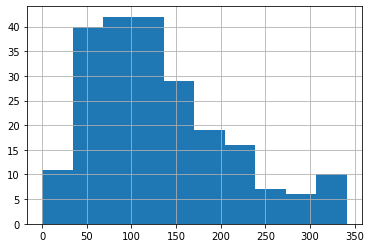

In [109]:
X.score.hist()

In [130]:
X['r_score'] = pd.cut(X['score'],bins=range(0,360+36,36)).astype(str)

In [138]:
isana=X.loc[:,'score'].isna()
igual=X.loc[:,'r_score']== 'nan'
#X.loc[X.loc[:,'score']>=50]
X.loc[151,'r_score'] = '(0.0, 36.0]'

In [71]:
#X.pivot_table(index='r_score',columns=tgt,values='score',aggfunc='count',fill_value=0).to_clipboard()

In [139]:
X.pivot_table(index='r_score',columns=tgt,values='score',aggfunc='count',fill_value=0).sort_index()

Carrera          0   1
r_score               
(0.0, 36.0]      0  12
(108.0, 144.0]   6  35
(144.0, 180.0]  19  12
(180.0, 216.0]  12   5
(216.0, 252.0]  11   0
(252.0, 288.0]   5   1
(288.0, 324.0]   9   0
(324.0, 360.0]   4   0
(36.0, 72.0]     1  43
(72.0, 108.0]    4  43

In [140]:
varw

['w_d_¬øQu√© promedio obtuviste en el bachillerato?_4_qua',
 'w_n_Escoger √©sta carrera fue...',
 'w_n_¬øCu√°l fue el proceso de admisi√≥n por el que entraste a esta carrera?',
 'w_n_¬øCu√°ndo tomaste la decisi√≥n de lo que quer√≠as estudiar?',
 'w_n_¬øEn d√≥nde cursaste el bachillerato?',
 'w_d_¬øCu√°ntos d√≠as a la semana dedicas tiempo para realizar las siguientes actividades? [Entretenimiento personal (videojuegos, redes sociales, netflix, youtube, etc)]_5_qua',
 'w_n_¬øRecibiste alguna beca?',
 'w_n_Al escoger la FES Acatl√°n √©sta fue:',
 'w_n_¬øC√≥mo se llama la instituci√≥n donde cursaste el bachillerato?',
 'w_d_¬øCu√°ntas personas en total viven en tu hogar? Incluy√©ndote a ti_5_qua',
 'w_d_¬øCu√°nto tiempo llevas viviendo ah√≠? (a√±os)_5_qua',
 'w_n_¬øCu√°l es el m√°ximo nivel de estudios de tu mam√°?',
 'w_n_¬øCu√°l es el m√°ximo nivel de estudios de tu pap√°?']

In [144]:
mapa_woe

[('d_¬øQu√© promedio obtuviste en el bachillerato?_4_qua',
  {'(6.999, 8.5]': 2.188684815788085,
   '(8.5, 8.815]': -1.3974349043680825,
   '(8.815, 9.1]': -0.9331292962369846,
   '(9.1, 10.0]': -0.8378191164326598}),
 ('n_Escoger √©sta carrera fue...',
  {'‚ù§Ô∏è Mi primera opci√≥n': -0.4166056513563563,
   'üòä Mi segunda opci√≥n': 3.6048321400576566}),
 ('n_¬øCu√°l fue el proceso de admisi√≥n por el que entraste a esta carrera?',
  {'Concurso de selecci√≥n': 1.3181625023695103,
   'Pase reglamentado': -0.381060713936945}),
 ('n_¬øCu√°ndo tomaste la decisi√≥n de lo que quer√≠as estudiar?',
  {'Al terminar el bachillerato': -0.061290326933663444,
   'Antes del bachillerato': -1.4256057813347789,
   'Durante el bachillerato': 0.1409919724228292,
   'En otro momento o circunstancia': 1.0593008684532212}),
 ('d_¬øEn cu√°ntos a√±os lo terminaste?_3_uni',
  {'(0.999, 2.333]': -inf,
   '(2.333, 3.667]': -0.10191007653463291,
   '(3.667, 5.0]': 1.8702310846695502}),
 ('n_¬øEn d√≥nde cursast

In [141]:
l = []
for v,d in mapa_woe:
    if 'w_%s'%v in varw:
        d = {y:x for x,y in d.items()}
        aux = X[['w_%s'%v,'pts_w_%s'%v]].copy()
        aux.drop_duplicates(inplace=True)
        aux['w_%s'%v].replace(d,inplace=True)
        aux.rename(columns={'w_%s'%v:'atributo','pts_w_%s'%v:'puntos'},inplace=True)
        aux['caracter√≠stica'] = v
        l.append(aux)

In [142]:
l

[       atributo  puntos                                     caracter√≠stica
 0  (6.999, 8.5]      60  d_¬øQu√© promedio obtuviste en el bachillerato?_...
 1  (8.5, 8.815]     -20  d_¬øQu√© promedio obtuviste en el bachillerato?_...
 3  (8.815, 9.1]     -10  d_¬øQu√© promedio obtuviste en el bachillerato?_...
 4   (9.1, 10.0]      -8  d_¬øQu√© promedio obtuviste en el bachillerato?_...,
                atributo  puntos                 caracter√≠stica
 0  ‚ù§Ô∏è Mi primera opci√≥n       0  n_Escoger √©sta carrera fue...
 5   üòä Mi segunda opci√≥n     106  n_Escoger √©sta carrera fue...,
                 atributo  puntos  \
 0      Pase reglamentado       5   
 5  Concurso de selecci√≥n      34   
 
                                       caracter√≠stica  
 0  n_¬øCu√°l fue el proceso de admisi√≥n por el que ...  
 5  n_¬øCu√°l fue el proceso de admisi√≥n por el que ...  ,
                            atributo  puntos  \
 0            Antes del bachillerato       1   
 1           Durant

In [76]:
scorecard = pd.concat(l,ignore_index=True)
scorecard

atributo  puntos  \
0                           (6.999, 8.5]      60   
1                           (8.5, 8.815]     -20   
2                           (8.815, 9.1]     -10   
3                            (9.1, 10.0]      -8   
4                   ‚ù§Ô∏è Mi primera opci√≥n       0   
5                    üòä Mi segunda opci√≥n     106   
6                      Pase reglamentado       5   
7                  Concurso de selecci√≥n      34   
8                 Antes del bachillerato       1   
9                Durante el bachillerato      12   
10           Al terminar el bachillerato      11   
11       En otro momento o circunstancia      19   
12  Escuela Nacional Preparatoria (UNAM)       8   
13                       Escuela p√∫blica      16   
14                                  Otro       9   
15                       Escuela privada      18   
16                            (5.0, 7.0]      24   
17                         (-0.001, 1.0]       1   
18                            (3.0, 5.0]      20   
19                            (2.0, 3.0]       1   
20                            (1.0, 2.0]      12   
21                                    S√≠       3   
22                                    No      26   
23             ‚òîÔ∏è No quer√≠a este plantel       0   
24                  ‚òÄÔ∏è Mi primera opci√≥n      19   
25                  ‚õÖÔ∏è Mi segunda opci√≥n      -4   
26                                 Otros      12   
27                                   CCH     -46   
28                         CCH Naucalpan      40   
29                            (3.0, 4.0]       4   
30                           (6.0, 12.0]       5   
31                            (4.0, 5.0]      13   
32                          (0.999, 3.0]      13   
33                            (5.0, 6.0]      21   
34                          (18.0, 35.0]      12   
35                          (11.4, 17.0]      12   
36                          (17.0, 18.0]      10   
37                           (5.0, 11.4]      12   
38                         (-0.001, 5.0]      11   
39                            Secundaria      28   
40                          Licenciatura      -6   
41                          Bachillerato      10   
42                              Primaria      10   
43         Posgrado, maestria, doctorado       5   
44                          Licenciatura       6   
45                            Secundaria      26   
46                                 Otros     -32   
47                          Bachillerato       5   
48                              Primaria      25   

                                       caracter√≠stica  
0   d_¬øQu√© promedio obtuviste en el bachillerato?_...  
1   d_¬øQu√© promedio obtuviste en el bachillerato?_...  
2   d_¬øQu√© promedio obtuviste en el bachillerato?_...  
3   d_¬øQu√© promedio obtuviste en el bachillerato?_...  
4                       n_Escoger √©sta carrera fue...  
5                       n_Escoger √©sta carrera fue...  
6   n_¬øCu√°l fue el proceso de admisi√≥n por el que ...  
7   n_¬øCu√°l fue el proceso de admisi√≥n por el que ...  
8   n_¬øCu√°ndo tomaste la decisi√≥n de lo que quer√≠a...  
9   n_¬øCu√°ndo tomaste la decisi√≥n de lo que quer√≠a...  
10  n_¬øCu√°ndo tomaste la decisi√≥n de lo que quer√≠a...  
11  n_¬øCu√°ndo tomaste la decisi√≥n de lo que quer√≠a...  
12              n_¬øEn d√≥nde cursaste el bachillerato?  
13              n_¬øEn d√≥nde cursaste el bachillerato?  
14              n_¬øEn d√≥nde cursaste el bachillerato?  
15              n_¬øEn d√≥nde cursaste el bachillerato?  
16  d_¬øCu√°ntos d√≠as a la semana dedicas tiempo par...  
17  d_¬øCu√°ntos d√≠as a la semana dedicas tiempo par...  
18  d_¬øCu√°ntos d√≠as a la semana dedicas tiempo par...  
19  d_¬øCu√°ntos d√≠as a la semana dedicas tiempo par...  
20  d_¬øCu√°ntos d√≠as a la semana dedicas tiempo par...  
21                          n_¬øRecibiste alguna beca?  
22                          n_¬øRecibiste alguna beca?  
23

In [77]:
with pd.ExcelWriter('scorecard.xlsx') as xl:
    scorecard.groupby(['caracter√≠stica','atributo']).max().to_excel(xl,sheet_name='scorecard')
    xl.close()